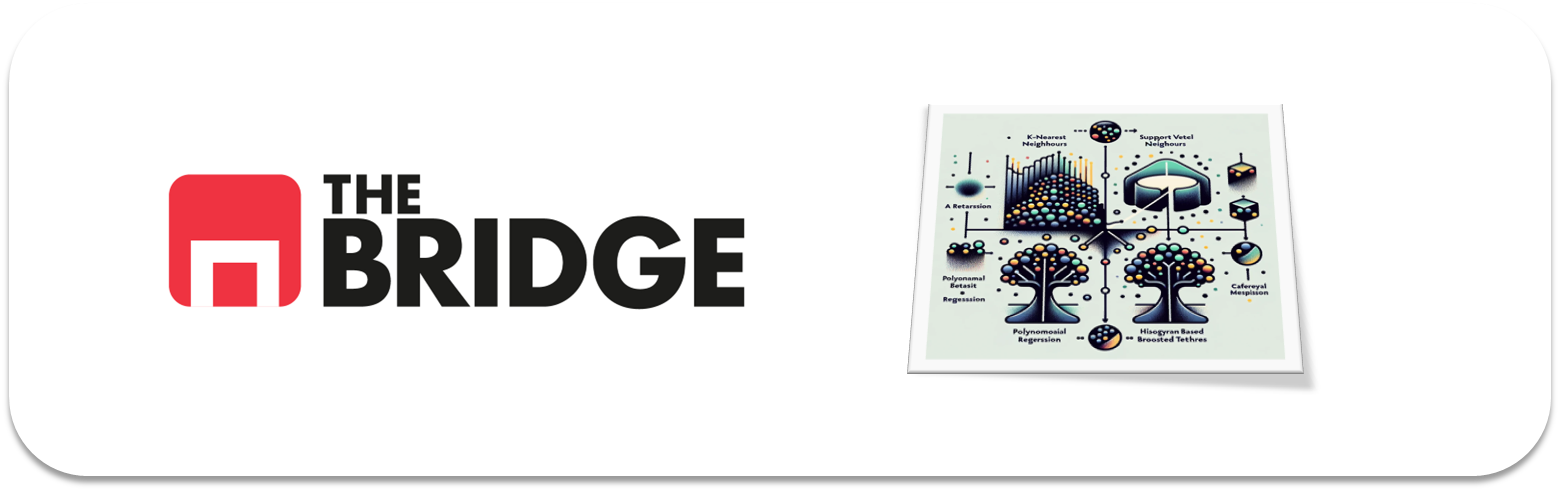

## PRACTICA OBLIGATORIA: **Otros Modelos Supervisados**

* La práctica obligatoria de esta unidad consiste en resolver un modelado de clasificación, incluyendo KNN entre los posibles modelos, y aplicando balanceado. Para ello utilizaremos un dataset que ya hemos empleado en los workout. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor 

### #1. El problema y los datos

Vamos a volver al dataset con el que vimos la clasificación binaria con regresión logística, "Give me some credit", y nuestro objetivo es crear un modelo que nos permita predicir si una persona va a encontrarse en dificultades financieras en los dos próximos años. El dataset de partida lo puedes en contrar en el directorio data que acompaña al ejercicio. 

### #1.1
Cárgalo y, apoyándote en las herramientas y fuentes que consideres necesarias, haz una descripción textual de sus variables. Luego con ayuda de los datos, haz una clasificación inicial de sus variables en categóricas y numéricas.

In [2]:
from scipy.stats import pearsonr, f_oneway, kruskal
from scipy.stats import chi2_contingency
df = pd.read_csv("F:\Bootcamp\Online_Ds_Thebridge-Santi-Arias-\credit_npo.csv")
def describe_df(df):
    """
    Devuelve un DataFrame con la descripción de cada columna del DataFrame de entrada.
    Muestra:
       - Tipo de dato
       - Porcentaje de valores nulos
       - Número de valores únicos
       - Porcentaje de cardinalidad

    Argumentos:
    df (pd.DataFrame): El DataFrame a describir.

    Retorna:
    pd.DataFrame: DataFrame con la información solicitada para cada columna.
    """

    # Listas para ir almacenando la información
    col_names = []
    dtypes = []
    perc_nulls = []
    unique_vals = []
    perc_cardinality = []

    n_rows = len(df)

    for col in df.columns:
        col_names.append(col)
        dtypes.append(df[col].dtype)

        # Porcentaje de nulos
        null_count = df[col].isna().sum()
        perc_null = (null_count / n_rows) * 100 if n_rows else 0
        perc_nulls.append(round(perc_null, 2))

        # Número de valores únicos
        nunique = df[col].nunique(dropna=False)
        unique_vals.append(nunique)

        # Porcentaje de cardinalidad
        perc_card = (nunique / n_rows) * 100 if n_rows else 0
        perc_cardinality.append(round(perc_card, 2))

    # Construimos el DataFrame de salida
    summary_df = pd.DataFrame({
        'columna': col_names,
        'tipo': dtypes,
        '%_nulos': perc_nulls,
        'valores_unicos': unique_vals,
        '%_cardinalidad': perc_cardinality
    })

    return summary_df

describe_df(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      12537 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  12537 non-null  float64
 2   age                                   12537 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  12537 non-null  int64  
 4   DebtRatio                             12537 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       12537 non-null  int64  
 7   NumberOfTimes90DaysLate               12537 non-null  int64  
 8   NumberRealEstateLoansOrLines          12537 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  12537 non-null  int64  
 10  NumberOfDependents                    12360 non-null  float64
dtypes: float64(4), 

In [15]:
def tipifica_variables(df, umbral_categoria=10, umbral_continua=0.2):
    """
    .
    """
    resultados = {
        'nombre_variable': [],
        'tipo_sugerido': []
    }
    n_rows = len(df)
    for col in df.columns:
        # Obtener el tipo de dato real
        dtype = df[col].dtype
        # Si el tipo de dato es 'category' o 'object', es categórico automáticamente
        if pd.api.types.is_categorical_dtype(dtype) or pd.api.types.is_object_dtype(dtype):
            tipo = 'Categórica'
        elif np.issubdtype(dtype, np.number):  # Si es numérico
            # Cardinalidad absoluta y relativa
            card_abs = df[col].nunique(dropna=False)
            card_rel = card_abs / n_rows if n_rows else 0
            # Clasificar como numérica
            if card_abs == 2:
                tipo = 'Binaria'
            elif card_abs < umbral_categoria:
                tipo = 'Categórica'
            else:
                if card_rel >= umbral_continua:
                    tipo = 'Numerica Continua'
                else:
                    tipo = 'Numerica Discreta'
        else:
            # Por seguridad, marcar como categórica cualquier otro tipo no esperado
            tipo = 'Categórica'
        # Guardar resultados
        resultados['nombre_variable'].append(col)
        resultados['tipo_sugerido'].append(tipo)
    return pd.DataFrame(resultados)
tipos_sujerido = tipifica_variables(df,10,0.2)
tipos_sujerido

C:\Users\samas\AppData\Local\Temp\ipykernel_12460\2436584602.py:14: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype) or pd.api.types.is_object_dtype(dtype):


,nombre_variable,tipo_sugerido
0,SeriousDlqin2yrs,Binaria
1,RevolvingUtilizationOfUnsecuredLines,Numerica Continua
2,age,Numerica Discreta
3,NumberOfTime30-59DaysPastDueNotWorse,Numerica Discreta
4,DebtRatio,Numerica Continua
5,MonthlyIncome,Numerica Continua
6,NumberOfOpenCreditLinesAndLoans,Numerica Discreta
7,NumberOfTimes90DaysLate,Numerica Discreta
8,NumberRealEstateLoansOrLines,Numerica Discreta
9,NumberOfTime60-89DaysPastDueNotWorse,Categórica


la variable target seria "SeriousDlqin2yrs" que es la variable que nos dice si se tendran problemas financieros en menos de 2 años. Esta misma es binaria por lo tanto su resultado tan solo puede ser 0 o 1

### #1.2
¿Qué tipo de problema estamos tratando? ¿Cuál es la variable target?

la variable target seria "SeriousDlqin2yrs" que es la variable que nos dice si se tendran problemas financieros en menos de 2 años. Esta misma es binaria por lo tanto su resultado tan solo puede ser 0 o 1. Y este es un problema de clasificacion.

### #1.3
Pinta la distribución de frecuencias del target y coméntala

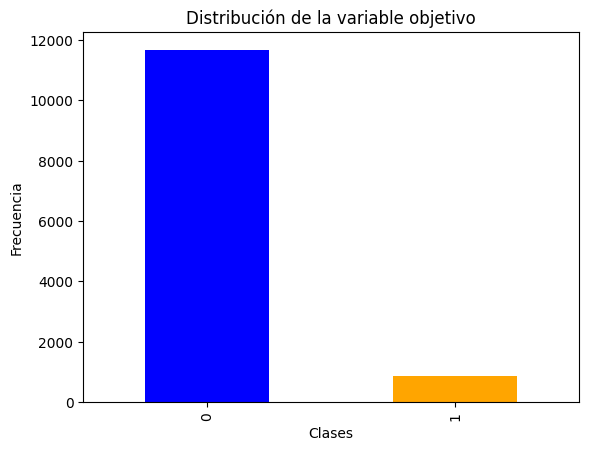

In [12]:
df['SeriousDlqin2yrs'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribución de la variable objetivo')
plt.xlabel('Clases')
plt.ylabel('Frecuencia')
plt.show()


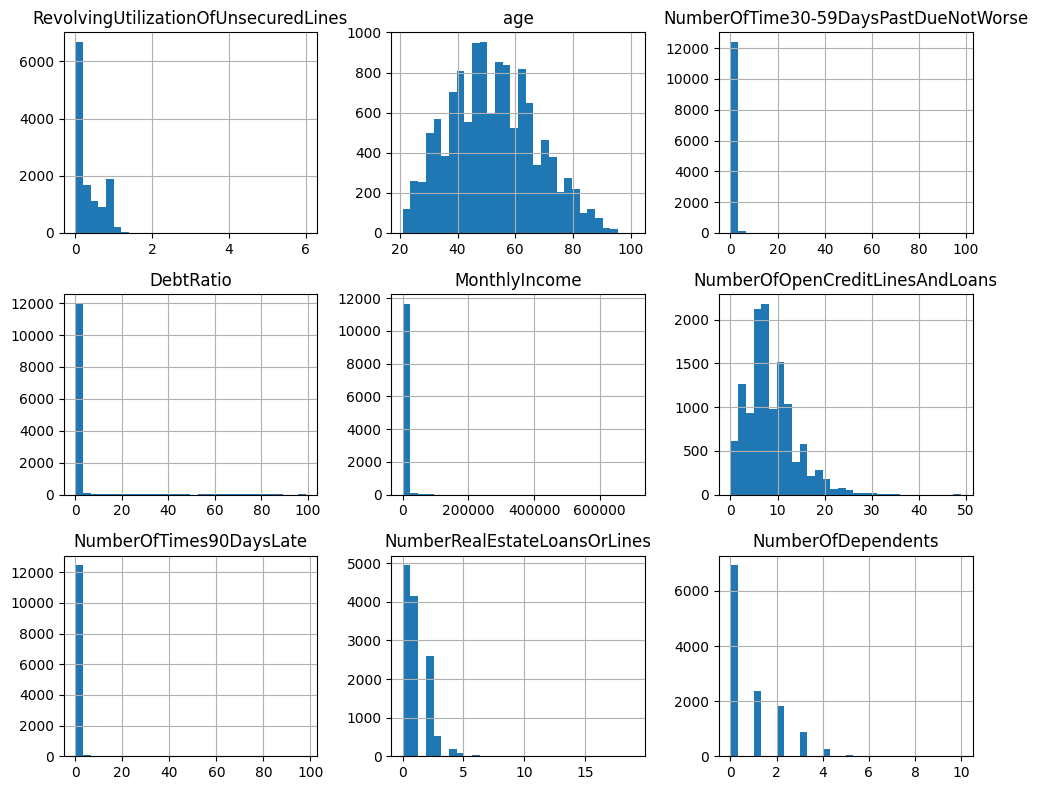

In [18]:
num_cols = ["RevolvingUtilizationOfUnsecuredLines","age","NumberOfTime30-59DaysPastDueNotWorse","DebtRatio","MonthlyIncome","NumberOfOpenCreditLinesAndLoans","NumberOfTimes90DaysLate","NumberRealEstateLoansOrLines","NumberOfDependents"]
df[num_cols].hist(bins=30, figsize=(10, 8))
plt.tight_layout()
plt.show()

In [21]:
df.isnull().sum()
df['MonthlyIncome'].fillna(df['MonthlyIncome'].median(), inplace=True)
df['NumberOfDependents'].fillna(df['NumberOfDependents'].median(), inplace=True)

C:\Users\samas\AppData\Local\Temp\ipykernel_12460\746748724.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['MonthlyIncome'].fillna(df['MonthlyIncome'].median(), inplace=True)
C:\Users\samas\AppData\Local\Temp\ipykernel_12460\746748724.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

### #2 Modelado

Realiza un proceso completo de modelado hasta dar con el mejor modelo de los que hayas escogido (emplea al menos 3, y uno tiene que ser KNN). Aplica las técnicas que creas necesarias para obtener el mejor resultado (suponiendo que este después de hablar con el negocio es el recall medio, para tener un compromiso entre las dos clases). Para comparar modelos emplea validación cruzada antes de optimización y luego ajusta los hiperparámetros del mejor modelo. Evalúa este y haz un pequeño análisis de errores.

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[num_cols] = scaler.fit_transform(df[num_cols])

from sklearn.model_selection import train_test_split
X = df_scaled.drop('SeriousDlqin2yrs', axis=1)
y = df_scaled['SeriousDlqin2yrs']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [26]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Dividir los datos en características y etiquetas
X = df_scaled.drop('SeriousDlqin2yrs', axis=1)
y = df_scaled['SeriousDlqin2yrs']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Aplicar SMOTE al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Verificar el equilibrio de las clases después de aplicar SMOTE
print("Distribución después de SMOTE:")
print(y_train_resampled.value_counts())

Distribución después de SMOTE:
SeriousDlqin2yrs
0    9338
1    9338
Name: count, dtype: int64


Mejores parámetros: {'n_neighbors': 2}
Mejor precisión: 0.9148875507284747
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      2335
           1       0.26      0.36      0.30       173

    accuracy                           0.89      2508
   macro avg       0.61      0.64      0.62      2508
weighted avg       0.90      0.89      0.89      2508



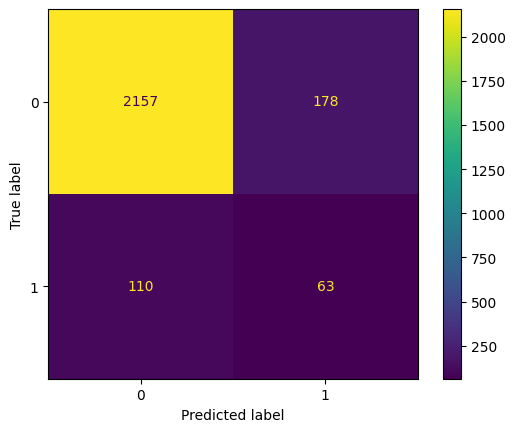

In [42]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
# Entrenar un modelo KNN
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train_resampled, y_train_resampled)

from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': range(1, 5)}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=4, scoring='precision')
grid_search.fit(X_train_resampled, y_train_resampled)

print("Mejores parámetros:", grid_search.best_params_)
print("Mejor precisión:", grid_search.best_score_)

# Predicciones y evaluación
y_pred_knn = knn.predict(X_test)
print(classification_report(y_test, y_pred_knn))

# Mostrar la matriz de confusión
ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test)
plt.show()




              precision    recall  f1-score   support

           0       0.97      0.76      0.86      2335
           1       0.18      0.70      0.29       173

    accuracy                           0.76      2508
   macro avg       0.58      0.73      0.57      2508
weighted avg       0.92      0.76      0.82      2508



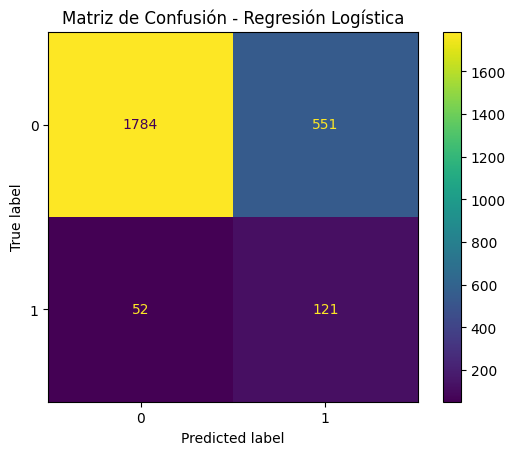

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV


# Inicializar y entrenar el modelo
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_resampled, y_train_resampled)

# Predicciones en el conjunto de prueba
y_pred_logreg = logreg.predict(X_test)

# Evaluar el modelo
print(classification_report(y_test, y_pred_logreg))

# Matriz de confusión
ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test)
plt.title('Matriz de Confusión - Regresión Logística')
plt.show()

Evaluación del modelo CatBoost:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      2335
           1       0.30      0.63      0.40       173

    accuracy                           0.87      2508
   macro avg       0.63      0.76      0.67      2508
weighted avg       0.92      0.87      0.89      2508



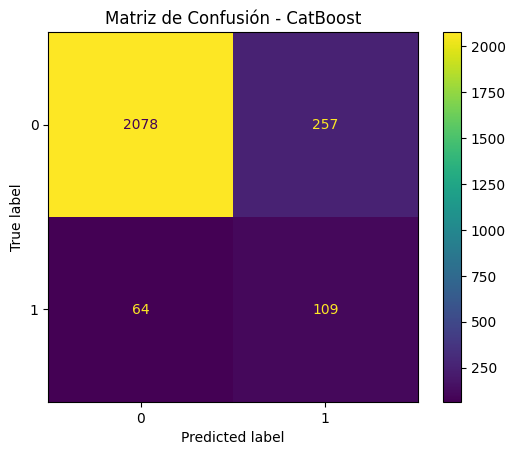

In [49]:

from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Inicializar el modelo CatBoost
cat_model = CatBoostClassifier(
    iterations=1000,      # Número de iteraciones
    learning_rate=0.1,   # Tasa de aprendizaje
    depth=6,             # Profundidad de los árboles
    eval_metric='Recall',# Métrica de evaluación
    random_seed=42,
    verbose=100          # Muestra progreso cada 100 iteraciones
)

# Entrenar el modelo
cat_model.fit(X_train_resampled, y_train_resampled, eval_set=(X_test, y_test), verbose=False)

# Predicciones
y_pred_cat = cat_model.predict(X_test)

# Evaluar el modelo
print("Evaluación del modelo CatBoost:")
print(classification_report(y_test, y_pred_cat))

# Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_cat)
plt.title('Matriz de Confusión - CatBoost')
plt.show()

De los 3 modelos que hemos testeado catboost es el que mejores resultado da.